# Biomedical Data Bases, 2020-2021
### Relational databases
These are the notes by prof. Davide Salomoni (d.salomoni@unibo.it) for the Biomedical Data Base course at the University of Bologna, academic year 2020-2021.

## SQLite
### Import sqlite3 and connect to it

In [1]:
import sqlite3 as sql

# create a connection to the DB
# if the DB does not exist, it will be created
# verify that after this statement you now have the DB file on your system
conn = sql.connect('sqlite_demo.db')

In [2]:
# get a cursor to the connection
cur = conn.cursor()

### Create some tables and perform basic operations

In [3]:
# create two tables
cur.execute('''DROP TABLE IF EXISTS Students;''')
cur.execute('''CREATE TABLE Students(
                id INTEGER PRIMARY KEY,
                first_name TEXT NOT NULL,
                last_name TEXT NOT NULL,
                age INTEGER,
                email TEXT NOT NULL UNIQUE);
            ''')
cur.execute('''DROP TABLE IF EXISTS Student_courses;''')
cur.execute('''CREATE TABLE Student_courses(
                id INTEGER PRIMARY KEY,
                student_id INTEGER NOT NULL,
                course_id INTEGER,
                course_name TEXT NOT NULL,
                FOREIGN KEY(student_id) REFERENCES Student(id));
            ''')

# commit the changes to the DB
conn.commit()

In [4]:
# insert a row
cur.execute('''INSERT INTO Students
                VALUES (1, 'John', 'Doe', 21, 'john@doe.com');''')

In [5]:
# insert the _same_ row again. It should fail because id is a primary key.
cur.execute('''INSERT INTO Students
                VALUES (1, 'John', 'Doe', 21, 'john@doe.com');''')

IntegrityError: UNIQUE constraint failed: Students.id

In [6]:
# delete a record
cur.execute('''DELETE FROM Students WHERE id=1;''')

In [7]:
# create a tuple with the students
the_students = (
    (1, 'John', 'Doe', 21, 'john@doe.com'),
    (2, 'Alice', 'Doe', 22, 'alice@doe.com'),
    (3, 'Rose', 'Short', 21, 'rose@short.com')
)

# and a tuple with the courses they follow
the_courses = (
    (1, 3, 102, 'BDB'),
    (2, 1, 110, 'BDP1'),
    (3, 3, 110, 'BDP1')
)

# now use executemany to insert the values into the tables
cur.executemany('''INSERT INTO Students VALUES(?, ?, ?, ?, ?)''', the_students)
cur.executemany('''INSERT INTO Student_courses VALUES(?, ?, ?, ?)''', the_courses)

In [8]:
cur.execute('SELECT * FROM Students')

In [9]:
print(cur.fetchall())

[(1, 'John', 'Doe', 21, 'john@doe.com'), (2, 'Alice', 'Doe', 22, 'alice@doe.com'), (3, 'Rose', 'Short', 21, 'rose@short.com')]


In [10]:
cur.execute('SELECT * FROM Student_courses')

In [11]:
print(cur.fetchall())

[(1, 3, 102, 'BDB'), (2, 1, 110, 'BDP1'), (3, 3, 110, 'BDP1')]


In [12]:
# select records based on some condition
cur.execute('SELECT * FROM Students WHERE id=3')
print(cur.fetchall())

[(3, 'Rose', 'Short', 21, 'rose@short.com')]


In [13]:
# remember to commit your changes!
conn.commit()

In [14]:
# and close the connection when done.
conn.close()

### Catching exceptions

In [15]:
# a better way to handle sqlite calls in python
try:
    conn = sql.connect('sqlite_demo.db')
    cur = conn.cursor()
    print("Connection successful")
    # put here all your DB processing stuff - do not forget to commit after changes to the db
    cur.execute('SELECT * FROM Students')
    print(cur.fetchall())
    # closing a _cursor_ is a good idea to reclaim memory
    cur.close()
except sql.Error as error:
    print("Error in SQLite:", error)
finally:
    # whatever happens, close the connection
    conn.close()

Connection successful
[(1, 'John', 'Doe', 21, 'john@doe.com'), (2, 'Alice', 'Doe', 22, 'alice@doe.com'), (3, 'Rose', 'Short', 21, 'rose@short.com')]


### Perform data analysis with pandas

Remember to copy the sample data set from GitHub and to put it in your bdb directory.

In [16]:
import pandas as pd
conn = sql.connect('gubbio_env_2018.sqlite')
df = pd.read_sql_query('SELECT * FROM gubbio', conn)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    8760 non-null   int64  
 1   month   8760 non-null   int64  
 2   day     8760 non-null   int64  
 3   hour    8760 non-null   int64  
 4   NO2     8760 non-null   float64
 5   O3      8760 non-null   float64
 6   PM10    8760 non-null   float64
 7   PM25    8760 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 547.6 KB


In [17]:
# how many NO2 entries are there with negative readings?
print(df.loc[df.NO2<0, 'NO2'])

1      -999.0
25     -999.0
49     -999.0
73     -999.0
97     -999.0
        ...  
8646   -999.0
8671   -999.0
8696   -999.0
8721   -999.0
8746   -999.0
Name: NO2, Length: 626, dtype: float64


In [18]:
# set the environmental readings to 0 if they are negative
df.loc[df.NO2<0, 'NO2'] = 0.0
df.loc[df.O3<0, 'O3'] = 0.0
df.loc[df.PM10<0, 'PM10'] = 0.0
df.loc[df.PM25<0, 'PM25'] = 0.0

In [19]:
# verify that now there are no NO2 readings < 0
print(df.loc[df.NO2<0, 'NO2'])

Series([], Name: NO2, dtype: float64)


In [20]:
# an example of how the to_datetime function works,
# applied to the year, month, day, and hour columns:
pd.to_datetime(df[['year', 'month', 'day', 'hour']])

0      2018-01-01 01:00:00
1      2018-01-01 02:00:00
2      2018-01-01 03:00:00
3      2018-01-01 04:00:00
4      2018-01-01 05:00:00
               ...        
8755   2018-12-31 20:00:00
8756   2018-12-31 21:00:00
8757   2018-12-31 22:00:00
8758   2018-12-31 23:00:00
8759   2019-01-01 00:00:00
Length: 8760, dtype: datetime64[ns]

In [21]:
# add a 'timerep' columns of datetime type
# combining the year, month, day, hour columns.
# Then check that it was created:
df['timerep'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.head()

,year,month,day,hour,NO2,O3,PM10,PM25,timerep
0,2018,1,1,1,20.595107,12.170429,23.5,11.74986,2018-01-01 01:00:00
1,2018,1,1,2,0.000000,11.423779,23.5,11.74986,2018-01-01 02:00:00
2,2018,1,1,3,24.490770,8.431690,23.5,11.74986,2018-01-01 03:00:00
3,2018,1,1,4,20.789195,10.564102,23.5,11.74986,2018-01-01 04:00:00
4,2018,1,1,5,15.802340,16.109878,23.5,11.74986,2018-01-01 05:00:00


In [22]:
# this is the current data frame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     8760 non-null   int64         
 1   month    8760 non-null   int64         
 2   day      8760 non-null   int64         
 3   hour     8760 non-null   int64         
 4   NO2      8760 non-null   float64       
 5   O3       8760 non-null   float64       
 6   PM10     8760 non-null   float64       
 7   PM25     8760 non-null   float64       
 8   timerep  8760 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 616.1 KB


In [23]:
# set timerep to be an index
# and then look what the current data frame looks like:
df.set_index('timerep', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 01:00:00 to 2019-01-01 00:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    8760 non-null   int64  
 1   month   8760 non-null   int64  
 2   day     8760 non-null   int64  
 3   hour    8760 non-null   int64  
 4   NO2     8760 non-null   float64
 5   O3      8760 non-null   float64
 6   PM10    8760 non-null   float64
 7   PM25    8760 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 615.9 KB


<AxesSubplot:xlabel='timerep'>

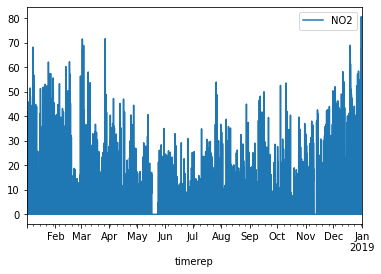

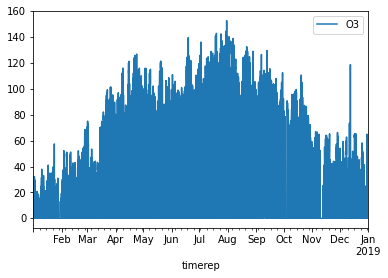

In [24]:
# now plot data
%matplotlib inline
df.plot(y=['NO2'])
df.plot(y=['O3'])

In [25]:
# close the connection before moving on.
conn.close()

In [26]:
# write the data frame to a new SQLite database
conn = sql.connect('gubbio_env_2018_custom.sqlite')
df.to_sql('gubbio', conn, if_exists='replace')
conn.close()

In [27]:
# read it back
conn = sql.connect('gubbio_env_2018_custom.sqlite')
df2 = pd.read_sql('SELECT * FROM gubbio', conn)
conn.close()

In [28]:
# check how the data frame looks like
df2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   timerep  8760 non-null   object 
 1   year     8760 non-null   int64  
 2   month    8760 non-null   int64  
 3   day      8760 non-null   int64  
 4   hour     8760 non-null   int64  
 5   NO2      8760 non-null   float64
 6   O3       8760 non-null   float64
 7   PM10     8760 non-null   float64
 8   PM25     8760 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 1.2 MB


<AxesSubplot:>

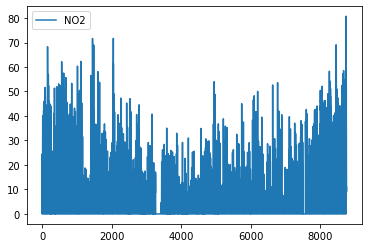

In [29]:
# the plot does not look right...
df2.plot(y=['NO2'])

In [30]:
# write the data frame to a new SQLite database again,
# but this time tell pandas to write an index to the DB
conn = sql.connect('gubbio_env_2018_custom.sqlite')
df.to_sql('gubbio', conn, if_exists='replace', index=True, index_label='timerep')
conn.close()

In [31]:
# read it back, but this time tell pandas that there is
# an index in the column 'timerep', of type datetime
conn = sql.connect('gubbio_env_2018_custom.sqlite')
df2 = pd.read_sql('SELECT * FROM gubbio', conn, index_col='timerep', parse_dates=['timerep'])
conn.close()

In [32]:
# check how the data frame looks like now
df2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 01:00:00 to 2019-01-01 00:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    8760 non-null   int64  
 1   month   8760 non-null   int64  
 2   day     8760 non-null   int64  
 3   hour    8760 non-null   int64  
 4   NO2     8760 non-null   float64
 5   O3      8760 non-null   float64
 6   PM10    8760 non-null   float64
 7   PM25    8760 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 615.9 KB


<AxesSubplot:xlabel='timerep'>

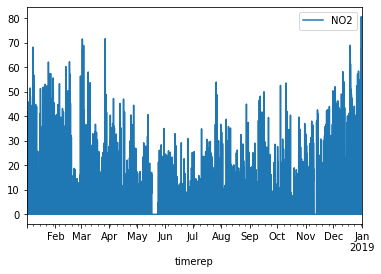

In [33]:
# the plot is now correct
df2.plot(y=['NO2'])

In [34]:
# check resampling aggregating by day
df.resample('D').mean()[['PM25']]

,PM25
timerep,
2018-01-01,11.749860
2018-01-02,11.192082
2018-01-03,18.430444
2018-01-04,17.345337
2018-01-05,18.981495
...,...
2018-12-28,43.645284
2018-12-29,35.085193
2018-12-30,36.215245


In [35]:
# find all days where PM10>50
df.resample('D').mean().query('PM10>50')[['PM10']]

,PM10
timerep,
2018-01-08,58.075001
2018-01-25,60.983334
2018-01-26,52.020825
2018-04-16,52.054168
2018-04-17,54.837502
2018-11-30,55.775001
2018-12-02,56.258334
2018-12-27,50.329159
2018-12-28,67.591669


In [36]:
# find all days where PM25>24
df.resample('D').mean().query('PM25>24')[['PM25']]

,PM25
timerep,
2018-01-07,31.444522
2018-01-08,32.166135
2018-01-25,32.424501
2018-01-26,30.520891
2018-01-29,29.445154
2018-01-30,25.206212
2018-02-16,24.072378
2018-04-16,27.824665
2018-04-17,27.290950


In [37]:
# find the yearly PM10 mean
df.resample('A').mean()[['PM10']]

,PM10
timerep,
2018-12-31,20.273660
2019-12-31,42.200001


In [38]:
# you may want just the first entry:
df.resample('A').mean()[['PM10']].head(1)

,PM10
timerep,
2018-12-31,20.27366


In [39]:
# find the yearly PM25 mean
df.resample('A').mean()[['PM25']]

,PM25
timerep,
2018-12-31,11.179227
2019-12-31,21.329750


In [40]:
# you may want just the first entry:
df.resample('A').mean()[['PM25']].head(1)

,PM25
timerep,
2018-12-31,11.179227
